In [1]:
using Revise

# first import the POMDPs.jl interface
using POMDPs

# import our helper Distributions.jl module
using Distributions

# POMDPToolbox has some glue code to help us use Distributions.jl
using POMDPToolbox

using DataFrames

# first let's load the value iteration module
using DiscreteValueIteration

In [2]:
struct GameState 
    batter_hand::Int64  # 0 for left, 1 for right
    pitcher_hand::Int64 # 0 for left, 1 for right
    outs::Int64         # number of outs
    balls::Int64        # number of balls
    strikes::Int64      # number of strikes
    base_code::Int64    # coded runners on base
    done::Bool          # are we in a terminal state?
end

In [3]:
struct Pitch
    pitch_code::Int64   # pitch type ie: curveball, fastball, ..
    x_loc::Int64        # x quantile of strike zone
    z_loc::Int64        # z quantile of strike zone
    switch_hand::Bool   # signal to switch pitcher hand
end

In [4]:
function getPrior(s::Int64, numStates::Int64, numActions::Int64, N::Array{Int64,3})
    prior = zeros(numStates)
    for a = 1:numActions
        prior = prior .+ N[s,a,:]
    end
    return prior./numActions
end

function computeTransitionDists(data::Array{Int64,2}, numStates::Int64, numActions::Int64)
    N = zeros(Int64,numStates, numActions, numStates)
    for i = 1:length(data[:,1])
        s = data[i,1]
        a = data[i,2]
        sp = data[i,4]
        N[s,a,sp] = N[s,a,sp] + 1
    end
    
    T = zeros(numStates, numStates, numActions)
    for s = 1:numStates
        prior = getPrior(s, numStates, numActions, N)
        for a = 1:numActions
            T[:,s,a] = prior .+ N[s,a,:]
            T[:,s,a] = T[:,s,a]./sum(T[:,s,a])
        end
        if any(isnan,T[:,s,:])
            T[:,s,:] = T[:,s-1,:]
        end
    end
    return T
end
;

In [5]:
# object declaration
type PitchCalling <: MDP{GameState, Pitch} # Note that our MDP is parametarized by the state and the action
    discount_factor::Float64 # discount factor
    T::Array{Float64,3}
    S::Array{GameState,1}
    A::Array{Pitch,1}
    switch_penalty::Float64
end

# constructor
function PitchCalling(;
                    discount_factor::Float64=0.99,
                    switch_penalty::Float64=-0.0)
    inputfilename = "../obs3.csv"
    s = GameState[]
    for batterhand = 0:1, pitcher_hand = 0:1, outs = 0:2, balls = 0:3, strikes = 0:2, base_code = 0:7
        push!(s, GameState(batterhand,pitcher_hand,outs,balls,strikes,base_code,false))
    end
    push!(s, GameState(2,0,0,0,0,0,true))
    
    a = Pitch[] # initialize an array of Pitches
    for pitch_code = 0:6, x_loc = 0:2, z_loc = 0:2
        push!(a, Pitch(pitch_code, x_loc, z_loc, false))
    end
    push!(a,Pitch(0,0,0,true))
    
    data = readtable(inputfilename)
    data = convert(Array{Int64}, data)
    T = computeTransitionDists(data, length(s), length(a))
    return PitchCalling(discount_factor, T, s, a, switch_penalty)
end

# states method
function POMDPs.states(mdp::PitchCalling)
    return mdp.S
end;

# actions method
function POMDPs.actions(mdp::PitchCalling)
    return mdp.A
end;

# transition method
function POMDPs.transition(mdp::PitchCalling, s::GameState, a::Pitch)
    s_i = state_index(mdp, s)
    a_i = action_index(mdp, a)
    if s.done
        return SparseCat([GameState(2,0,0,0,0,0,true)], [1.0])
    elseif a.switch_hand
        sp = GameState(s.batter_hand,(s.pitcher_hand+1)%2,s.outs,s.balls,s.strikes,s.base_code,s.done)
        return SparseCat([sp],[1.0])
    else
        return SparseCat(mdp.S,mdp.T[:,s_i,a_i])
    end
end

function numRunners(state::GameState)
    if state.base_code in (0)
        return 0
    elseif state.base_code in (1, 2, 3)
        return 1
    elseif state.base_code in (4, 5, 6)
        return 2
    else
        return 3
    end
end

# reward method
function POMDPs.reward(mdp::PitchCalling, s::GameState, a::Pitch, sp::GameState)
    if s.done
        return 0.0
    elseif a.switch_hand
        return mdp.switch_penalty 
    else
        return -(numRunners(s) - numRunners(sp) + 1 - (sp.outs) + (s.outs))
    end
end

# miscellaneous methods
POMDPs.n_states(mdp::PitchCalling) = length(mdp.S)
POMDPs.n_actions(mdp::PitchCalling) = length(mdp.A)
POMDPs.discount(mdp::PitchCalling) = mdp.discount_factor;

function POMDPs.state_index(mdp::PitchCalling, s::GameState)
    if s.done
        return 1153
    else
        return convert(Int64,s.batter_hand*576 + s.pitcher_hand*288 + s.outs*96 + s.balls*24 + s.strikes*8 + s.base_code + 1)
    end
end

function POMDPs.action_index(mdp::PitchCalling, a::Pitch)
    if a.switch_hand
        return 64
    else
        return convert(Int64,a.pitch_code*9 + a.x_loc*3 + a.z_loc + 1)
    end
end

POMDPs.isterminal(mdp::PitchCalling, s::GameState) = s.done

In [6]:
#=mdp = PitchCalling()
sim(mdp, GameState(0,0,0,0,0,0,false), max_steps=100) do s
    println("state is: $s")
    a = Pitch(rand(0:6), rand(0:2), rand(0:2),rand([true,false]))
    println("throwing $a")
    return a
end
;=#

In [7]:
#=s_i = state_index(mdp, GameState(0,1,0,1,1,0,false))
a_i = action_index(mdp, Pitch(1,2,0,false))
for s = 1:n_states(mdp)
    if any(isnan,mdp.T[:,s,:])
        println("state is: $s")

    end
end=#

In [8]:
# initialize the problem
mdp = PitchCalling()

# initialize the solver
# max_iterations: maximum number of iterations value iteration runs for (default is 100)
# belres: the value of Bellman residual used in the solver (defualt is 1e-3)
solver = ValueIterationSolver(max_iterations=1000, belres=1e-3)

# initialize the policy by passing in your problem
policy = ValueIterationPolicy(mdp) 

# solve for an optimal policy
# if verbose=false, the text output will be supressed (false by default)
solve(solver, mdp, policy, verbose=true);

[Iteration 1   ] residual:      0.829 | iteration runtime:   1025.683 ms, (      1.03 s total)
[Iteration 2   ] residual:      0.481 | iteration runtime:   1038.311 ms, (      2.06 s total)
[Iteration 3   ] residual:      0.218 | iteration runtime:    964.771 ms, (      3.03 s total)
[Iteration 4   ] residual:     0.0258 | iteration runtime:   1063.027 ms, (      4.09 s total)
[Iteration 5   ] residual:    0.00516 | iteration runtime:    903.258 ms, (         5 s total)
[Iteration 6   ] residual:    0.00101 | iteration runtime:    903.659 ms, (       5.9 s total)
[Iteration 7   ] residual:    0.00018 | iteration runtime:    892.976 ms, (      6.79 s total)


In [9]:
function write_Policy(policy::DiscreteValueIteration.ValueIterationPolicy, score::Float64)
    open(outputfilename, "a") do io
        @printf(io, "Policy Score: %f\n", score)
        @printf(io, "Baseline Score: %f\n", baseline)
        @printf(io, "Pitcher Switch Cost: %f\n", mdp.switch_penalty)
        for s in mdp.S
            a = action(policy,s)
            if a.switch_hand
                @printf(io, "%d\tSwitch pitcher hand\n", action_index(mdp,a))
            else
                @printf(io, "%d\tPitch code: %i\tX_loc: %i\tZ_loc: %i\n", action_index(mdp,a), a.pitch_code, a.x_loc, a.z_loc)
            end
        end
    end
end

function computePolicyScore(policy::DiscreteValueIteration.ValueIterationPolicy)
    U = zeros(length(mdp.S),1)
    for i = 100
        for s in mdp.S
            if state_index(mdp,s) == 289
                continue
            end
            s_i = state_index(mdp,s)
            a_i = action_index(mdp,action(policy,s))
            U[s_i] = R[s_i,a_i] + sum(mdp.T[:,s_i,a_i].*U[:])
        end
    end
    return sum(U)
end

function computePolicyScore(Pi::Array{Int64,1})
    U = zeros(kNumStates,1)
    for i = 1:100
        for s = 1:(kNumStates-1)
            U[s] = R[s,Pi[s]] + sum(mdp.T[:,s,Pi[s]].*U[:])
        end
    end
    return sum(U)
end

function computeRewardMatrix(data::Array{Int64,2})
    N = zeros(Int64,kNumStates, kNumActions, kNumStates)
    for i = 1:length(data[:,1])
        s = data[i,1]
        a = data[i,2]
        sp = data[i,4]
        N[s,a,sp] = N[s,a,sp] + 1
    end

    R = zeros(kNumStates, kNumActions)
    counts = zeros(kNumStates, kNumActions)
    for i = 1:length(data[:,1])
        s = data[i,1]
        a = data[i,2]
        r = data[i,3]
        counts[s,a] = counts[s,a] + 1
        rhat = r/sum(N[s,a,:])
        R[s,a] = R[s,a] + (rhat - R[s,a])/counts[s,a]
    end
    return R
end

function computeBaselineScore()
    aveScore = 0.0
    n = 100
    for i = 1:n
        Pi = rand(1:(kNumActions-1),kNumStates)
        score = computePolicyScore(Pi)
        @printf("Random Policy Score: %f\r\n", score)
        aveScore = aveScore + score
    end
    aveScore = aveScore/n
    @printf("Average of 100 Random Policy Scores: %f\r\n", aveScore)  
    return aveScore
end

kNumStates = n_states(mdp)
kNumActions = n_actions(mdp)
inputfilename = "../obs3.csv"
outputfilename = "./Results_Handedness/Value_Iteration/run5.policy"
data = readtable(inputfilename)
data = convert(Array{Int64}, data)
R = computeRewardMatrix(data)
baseline = -404.222542#computeBaselineScore()
write_Policy(policy, computePolicyScore(policy));

In [14]:
mdp =  PitchCalling() # run once to trigger compilation
Profile.clear()  # in case we have any previous profiling data
@profile mdp =  PitchCalling();

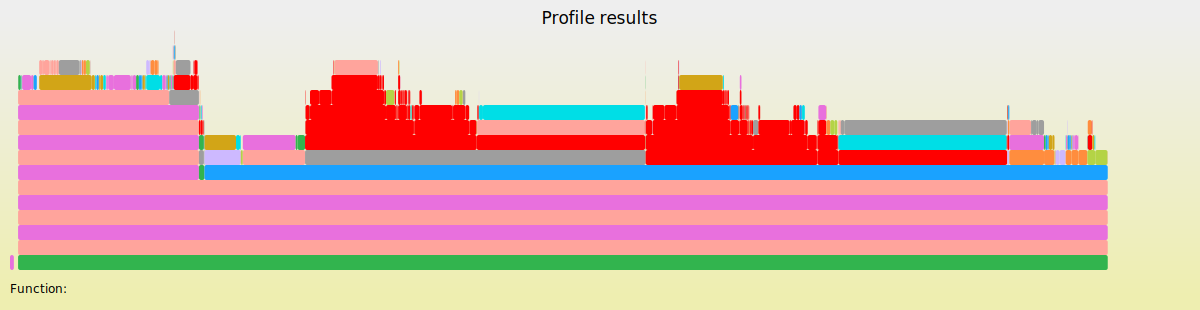

In [16]:
ProfileView.view()

In [18]:
mdp.T[:,1153,:]

1153×64 Array{Float64,2}:
 0.0222222  0.0150754  0.0114068  …  0.0222222  0.00767263  0.0222222
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0        …  0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0        …  0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 0.0        0.0        0.0           0.0        0.0         0.0      
 ⋮                                ⋱                             